In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

plt.style.use("ggplot")
pyro.set_rng_seed(1209)
np.random.seed(1209)
figsize = (7, 5)


# ToDo

* check Oswin notes for neg_log_likelihood

* Check if loss calculation is the same as getting mu and cov from model.

In [79]:
def g(x):
    return -(torch.sin(6 * torch.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


In [80]:
def neg_log_likelihood(x, y, GP):
    kernel = GP.kernel
    noise_y = GP.noise
    n_samples = len(x)
    K = kernel.forward(x)

    # ToDo mention that we are using the Cholesky decomposition
    # for the numerical stability of the computation
    # and for performance reasons
    # also add reference to the book

    # Compute the Cholesky decomposition
    upper = False
    L = torch.linalg.cholesky(K + noise_y * torch.eye(n_samples), upper=upper)

    alpha = torch.cholesky_solve(y.reshape(-1, 1), L, upper=upper)
    alpha = alpha.squeeze()
    # L being a diagonal matrix has the determinant equal to the sum of the log of
    # the element on the diagonal
    log_det = torch.sum(torch.log(torch.diag(L)))

    # Negative log-likelihood
    NLL = -0.5 * (
        torch.dot(y.T, alpha)
        + log_det
        + n_samples * torch.log(torch.tensor(2.0) * torch.pi)
    )

    return NLL

In [81]:
def neg_likelihood_prior_joint(x, y, GP, priors):
    params = [
        GP.noise,
        kernel.kern0.lengthscale,
        kernel.kern0.variance,
        kernel.kern1.variance,
        kernel.kern1.period,
        kernel.kern1.lengthscale,
    ]

    neg_likelihood = neg_log_likelihood(x, y, GP)
    log_prob_prior = torch.tensor(0.0)
    for distribution, value in zip(priors, params):
        log_prob_prior += distribution.log_prob(value)

    return neg_likelihood - log_prob_prior


## Plot of generating function $g$

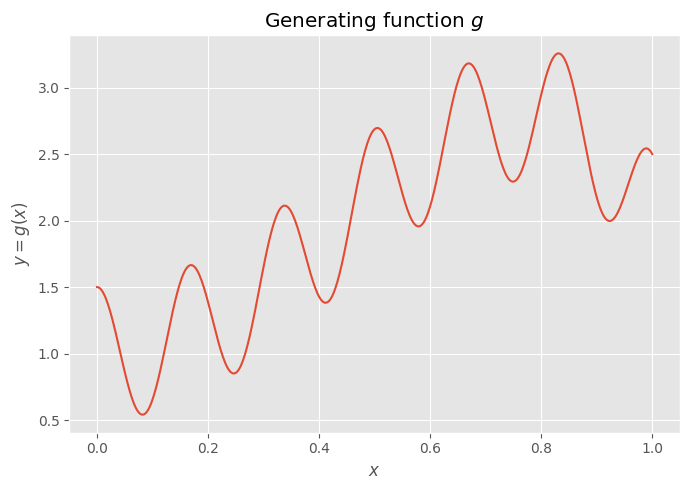

In [82]:
n_points = 500
xs = torch.linspace(0.0, 1.0, n_points)
ys = g(xs)

fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys)
ax.set_title(r"Generating function $g$")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
plt.tight_layout()
plt.show()


# Training and test data

We assume observations are given by:

$$
y_i = g(x_i) + \epsilon_i, \quad 
$$

where the observations are the grid $x_i = \frac{i-1}{l-1}, i=1,\ldots,l$ with $l=30$.

In [83]:
def generate_data(l=30, split=1.0 / 3.0):
    """
    Generate training and test data for the function g(x) = -(sin(6*pi*x)^2) + 6x^2 - 5x^4 + 3/2.
    :param l: Number of data points.
    :param split: Fraction of data to use as test data.
    :return: x_train, y_train, x_test, y_test
    """
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + torch.sqrt(torch.tensor(0.01)) * torch.randn(len(x))

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=split, random_state=3317
    )

    return x_train, y_train, x_test, y_test

In [84]:
x_train, y_train, x_test, y_test = generate_data()

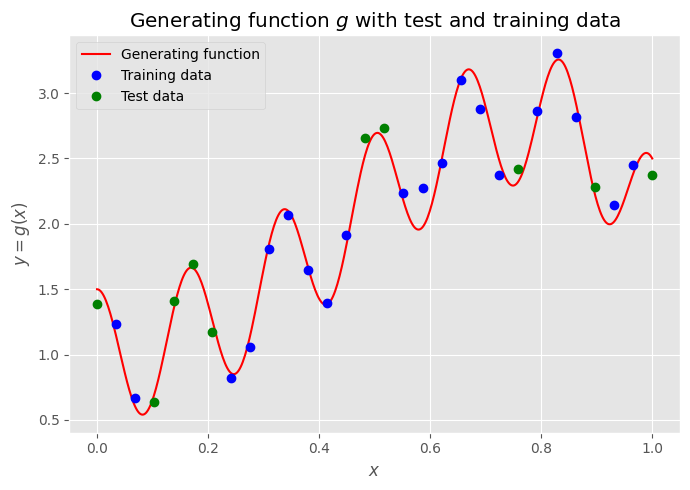

In [85]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(xs, ys, label="Generating function", color="red")
ax.plot(x_train, y_train, "o", label="Training data", color="blue")
ax.plot(x_test, y_test, "o", label="Test data", color="green")
ax.set_title(r"Generating function $g$ with test and training data")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y=g(x)$")
ax.legend()
plt.tight_layout()
plt.show()


## Setup Gaussian kernel

In [86]:
# Choice of kernel:
# Data is periodic, so we use a periodic kernel
# Data is increasing, so we use a linear kernel
# Sum of kernels is also a kernel
# We use a sum of a linear and a periodic kernel
# The periodic kernel is due to David Mackey: Introduction to Gaussian Processes, eq. 47
# Kernel cookbook: https://www.cs.toronto.edu/~duvenaud/cookbook/

# the linear kernel alone is equivalent to a linear regression

# refer to the "the kernel cookbook" for more information on kernels

# play around with the hyperparameters to see how they affect the model

linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))


rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1.0)
)

periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(1 / 6),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)

kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)


## Perform GP regression with chosen kernel

Note this is done for a fixed set of kernel parameters.

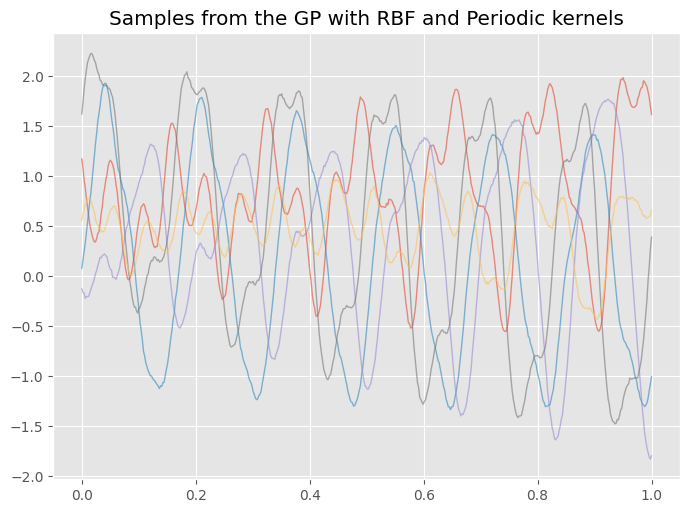

In [87]:
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Samples from the GP
n_samples = 5

cov = kernel.forward(xs)
samples = dist.MultivariateNormal(
    torch.zeros(n_points),
    covariance_matrix=cov
    + torch.diag(torch.ones(n_points) * 0.0001),  ## ToDo should noise be added here?
).sample(sample_shape=(n_samples,))

fig, ax = plt.subplots(figsize=figsize)

for sample in samples:
    ax.plot(xs, sample, lw=1, alpha=0.6)

plt.tight_layout()
plt.title("Samples from the GP with RBF and Periodic kernels")
plt.show()


## Plot GP regression (no tuning of hyperparameters)

This is just a sanity check to see if model is capable of matching data

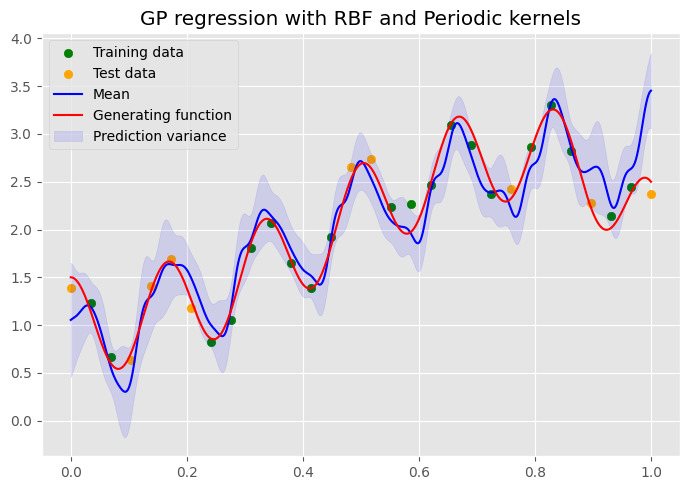

In [92]:
with torch.no_grad():
    mean, cov = gpr(xs, noiseless=False)

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(x_train, y_train, label="Training data", color="green")
ax.scatter(x_test, y_test, label="Test data", color="orange")
ax.plot(xs, mean, label="Mean", color="blue")
ax.plot(xs, ys, label="Generating function", color="red")
ax.fill_between(
    xs,
    mean + torch.sqrt(cov) * 1.95996,
    mean - torch.sqrt(cov) * 1.95996,
    color="blue",
    alpha=0.1,
    label="Prediction variance",
)
ax.set_title("GP regression with RBF and Periodic kernels")
ax.legend()
plt.tight_layout()
plt.savefig("./figures/gp_regression.png", dpi=600)
plt.show()

In [70]:
mu_noise = 0.01  # Expected noise variance
cv_noise = 1.0  # Coefficient of variation

# Calculate alpha and beta
alpha_noise = (1 / cv_noise) ** 2
beta_noise = alpha_noise / mu_noise
print(f"alpha_noise: {alpha_noise}, beta_noise: {beta_noise}")

alpha_noise: 1.0, beta_noise: 100.0


## Use gradient descent to find optimal hyperparameters $\theta$

In [71]:
losses_list = []
neg_likelihood_prior_joints_list = []
test_loglikelihoods = []
gaussian_processes = []

generated_data_list = []

smoke_test = False
iterations = 20 if not smoke_test else 4

for i in range(iterations):
    print(f"Iteration {i + 1}/{iterations}")
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = generate_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    linear = gp.kernels.Linear(input_dim=1, variance=torch.tensor(2.0))

    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(1 / 3),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Product(kern0=rbf, kern1=periodic)
    # kernel = periodic
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    # RBF kernel
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.5, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    # Periodic kernel
    gpr.kernel.kern1.period = pyro.nn.PyroSample(
        dist.LogNormal(torch.log(torch.tensor(1 / 6)), 0.1)
    )
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(1.4, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(alpha_noise, beta_noise))

    priors = [  # disse kan defineres udenfor loop
        dist.Gamma(alpha_noise, beta_noise),  # noise
        dist.LogNormal(0.5, 1),  # RBF lengthscale
        dist.LogNormal(0, 1),  # RBF variance
        dist.LogNormal(0, 1),  # Periodic variance
        dist.LogNormal(torch.log(torch.tensor(1 / 6)), 0.1),  # Periodic period
        dist.LogNormal(1.4, 1),  # Periodic lengthscale
    ]

    # SVI with delta distribution as guide
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss  # ToDO er der andre loss fns
    losses = []
    neg_likelihood_prior_joints = []
    num_steps = 3000
    for i in tqdm(range(num_steps)):
        gpr.set_mode("model")
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        gpr.set_mode("guide")
        neg_likelihood_prior_joints.append(
            neg_likelihood_prior_joint(x_train, y_train, gpr, priors).detach().numpy()
        )

    gpr.set_mode("guide")

    losses_list.append(losses)
    neg_likelihood_prior_joints_list.append(neg_likelihood_prior_joints)
    test_loglikelihoods.append(neg_log_likelihood(x_test, y_test, gpr))

    gaussian_processes.append(gpr)


Iteration 1/20


100%|██████████| 3000/3000 [00:07<00:00, 417.88it/s]


Iteration 2/20


100%|██████████| 3000/3000 [00:06<00:00, 435.64it/s]


Iteration 3/20


100%|██████████| 3000/3000 [00:07<00:00, 423.71it/s]


Iteration 4/20


100%|██████████| 3000/3000 [00:06<00:00, 439.12it/s]


Iteration 5/20


100%|██████████| 3000/3000 [00:06<00:00, 441.03it/s]


Iteration 6/20


100%|██████████| 3000/3000 [00:06<00:00, 433.80it/s]


Iteration 7/20


100%|██████████| 3000/3000 [00:06<00:00, 439.87it/s]


Iteration 8/20


100%|██████████| 3000/3000 [00:06<00:00, 442.92it/s]


Iteration 9/20


100%|██████████| 3000/3000 [00:06<00:00, 443.54it/s]


Iteration 10/20


100%|██████████| 3000/3000 [00:07<00:00, 423.01it/s]


Iteration 11/20


100%|██████████| 3000/3000 [00:07<00:00, 428.20it/s]


Iteration 12/20


100%|██████████| 3000/3000 [00:07<00:00, 417.68it/s]


Iteration 13/20


100%|██████████| 3000/3000 [00:06<00:00, 443.85it/s]


Iteration 14/20


100%|██████████| 3000/3000 [00:06<00:00, 438.27it/s]


Iteration 15/20


100%|██████████| 3000/3000 [00:06<00:00, 445.37it/s]


Iteration 16/20


100%|██████████| 3000/3000 [00:06<00:00, 448.27it/s]


Iteration 17/20


100%|██████████| 3000/3000 [00:06<00:00, 444.78it/s]


Iteration 18/20


100%|██████████| 3000/3000 [00:06<00:00, 449.48it/s]


Iteration 19/20


100%|██████████| 3000/3000 [00:06<00:00, 452.45it/s]


Iteration 20/20


100%|██████████| 3000/3000 [00:06<00:00, 451.77it/s]


In [72]:
map_test_log_likelihood = [x.detach().item() for x in test_loglikelihoods]
map_test_log_likelihood


[-11.739569664001465,
 -10.372503280639648,
 -10.630261421203613,
 -11.856077194213867,
 -18.365325927734375,
 -14.903423309326172,
 -10.197603225708008,
 -10.638860702514648,
 -12.914301872253418,
 -9.359822273254395,
 -10.395574569702148,
 -11.220866203308105,
 -11.83434009552002,
 -9.190084457397461,
 -15.740955352783203,
 -10.94947624206543,
 -10.125082015991211,
 -21.8223934173584,
 -13.305448532104492,
 -14.780899047851562]

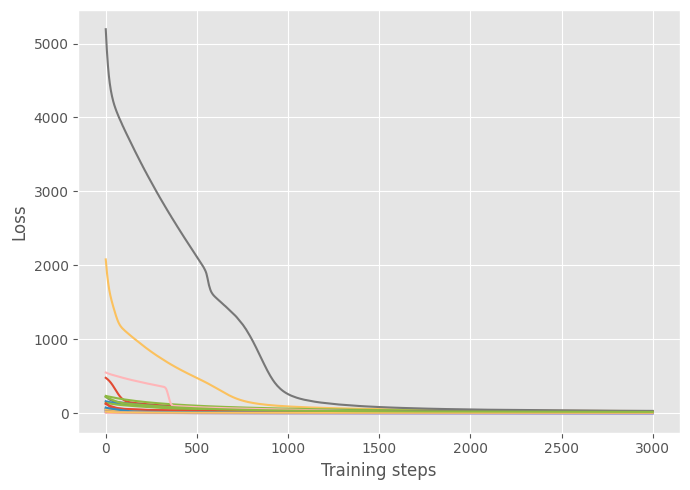

In [73]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel("Loss")
for l in losses_list:
    ax.plot(l)

plt.tight_layout()
plt.show()


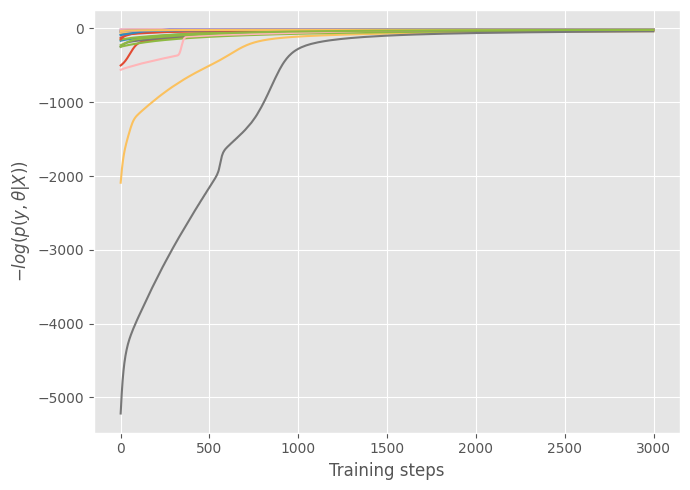

In [74]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Training steps")
ax.set_ylabel(r"$-log(p(y, \theta | X))$")
for l in neg_likelihood_prior_joints_list:
    ax.plot(l)

plt.tight_layout()
plt.show()


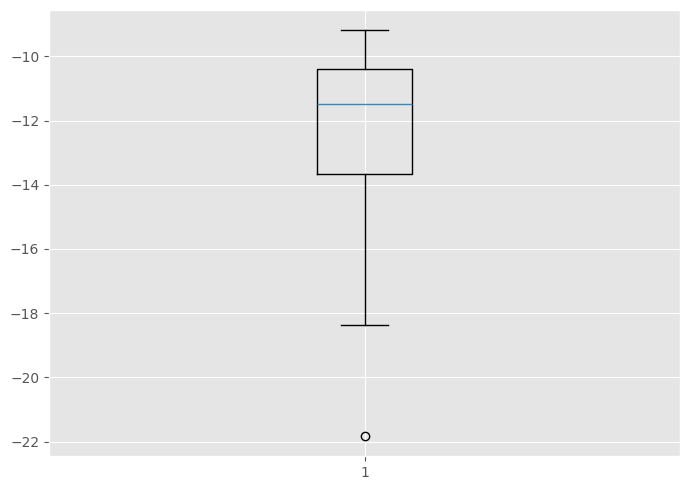

In [75]:
[x.detach().item() for x in test_loglikelihoods]

fig, ax = plt.subplots(figsize=figsize)

ax.boxplot([x.detach().item() for x in test_loglikelihoods])
plt.tight_layout()
plt.show()


# Måske histogrammer af MAPs

In [76]:
def plotfct(generated_data_list, xs, ys, mean, cov, i):
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        generated_data_list[i][0],
        generated_data_list[i][1],
        color="blue",
        label="Train data",
    )  # plot train data
    ax.scatter(
        generated_data_list[i][2],
        generated_data_list[i][3],
        color="red",
        label="Test data",
    )  # plot test data
    ax.plot(xs, mean, color="blue", label="Prediction mean")  # plot mean
    ax.plot(xs, ys, color="orange", label=r"$g(x)$")  # plot g(x)
    ax.fill_between(
        xs,
        mean + torch.sqrt(cov) * 1.95,
        mean - torch.sqrt(cov) * 1.95,
        color="blue",
        alpha=0.1,
        label="Prediction variance",
    )  # plot var
    ax.set_title(
        f"GP regression with sum of RBF and Periodic kernels - iteration {i+1}"
    )
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"./figures/gp_{i+1}.png")
    plt.show()

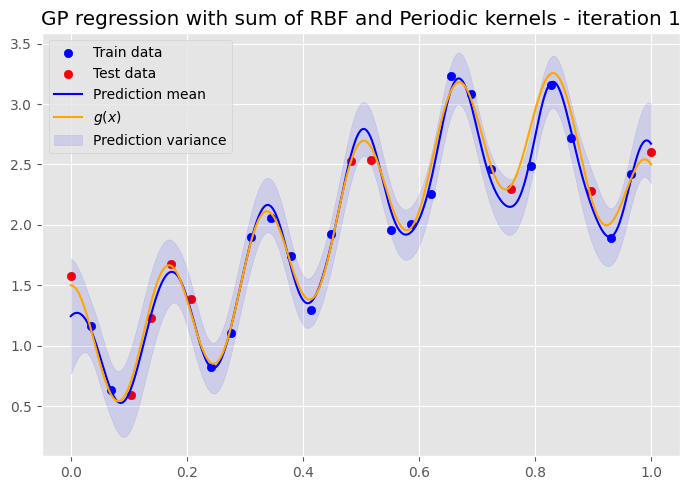

RBF length 0.46035754680633545 var 0.7722840309143066
PERIODIC per 0.16183987259864807 length 3.218524932861328 var 1.392232894897461


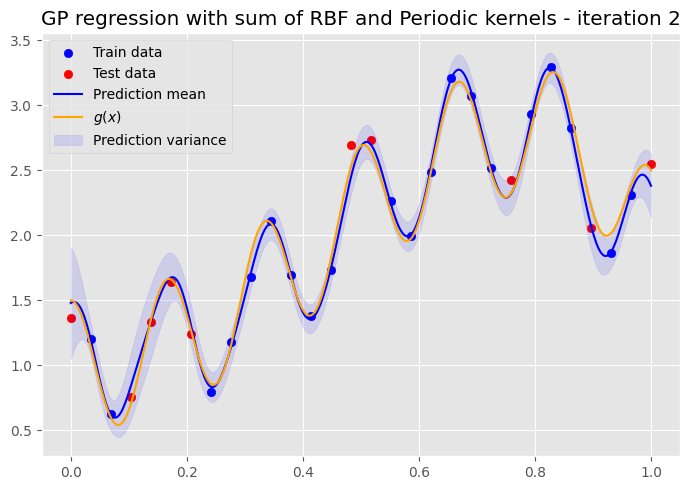

RBF length 0.3916804790496826 var 1.2933158874511719
PERIODIC per 0.16575570404529572 length 3.9250643253326416 var 1.2500553131103516


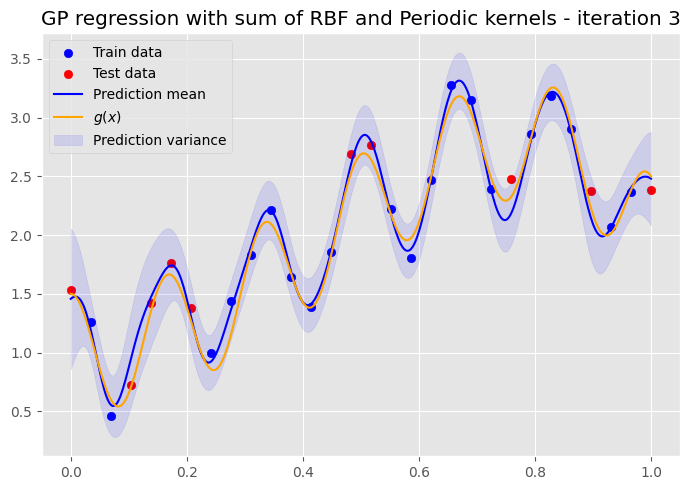

RBF length 0.41063427925109863 var 1.199716329574585
PERIODIC per 0.1610250473022461 length 3.01906681060791 var 1.19866943359375


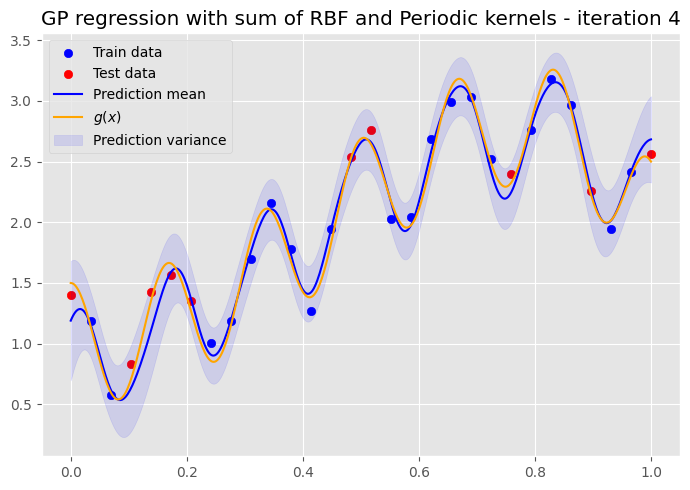

RBF length 0.4617459177970886 var 1.8772335052490234
PERIODIC per 0.1689700484275818 length 3.1699557304382324 var 0.5252843499183655


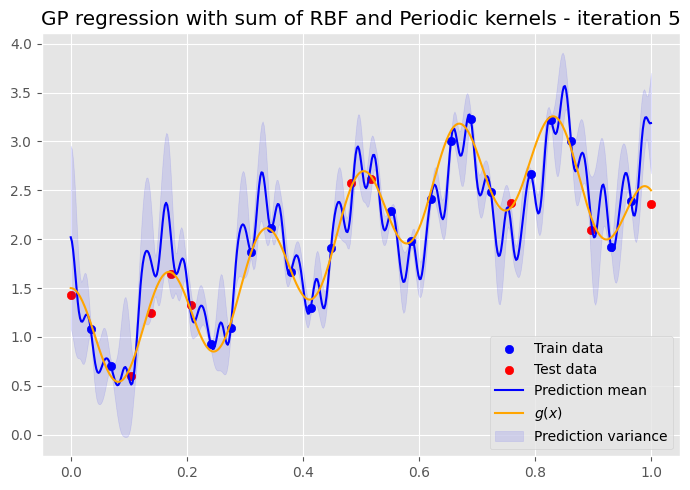

RBF length 1.0373791456222534 var 1.446829080581665
PERIODIC per 0.1644551008939743 length 0.5743134617805481 var 0.9097542762756348


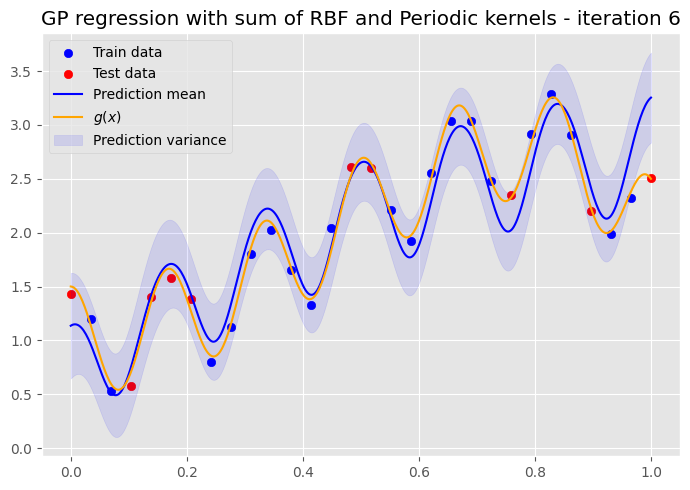

RBF length 1.4362504482269287 var 2.8389577865600586
PERIODIC per 0.16953802108764648 length 5.355007171630859 var 1.732528805732727


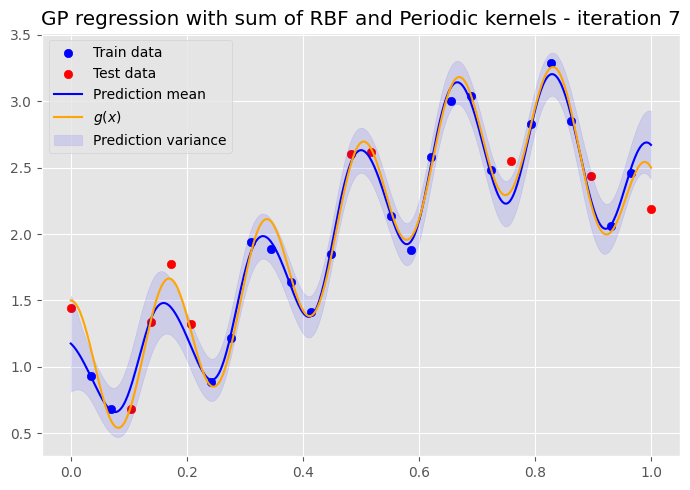

RBF length 0.48712435364723206 var 1.2445091009140015
PERIODIC per 0.16715234518051147 length 4.876408576965332 var 1.2445201873779297


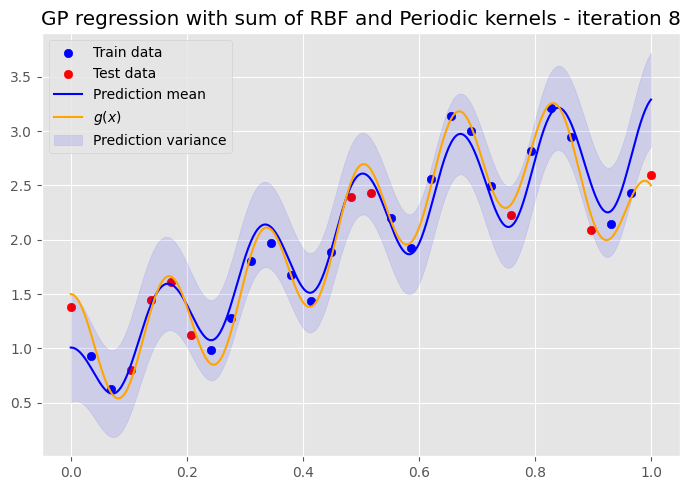

RBF length 1.3850892782211304 var 1.7971019744873047
PERIODIC per 0.1705106794834137 length 6.040910720825195 var 2.739856243133545


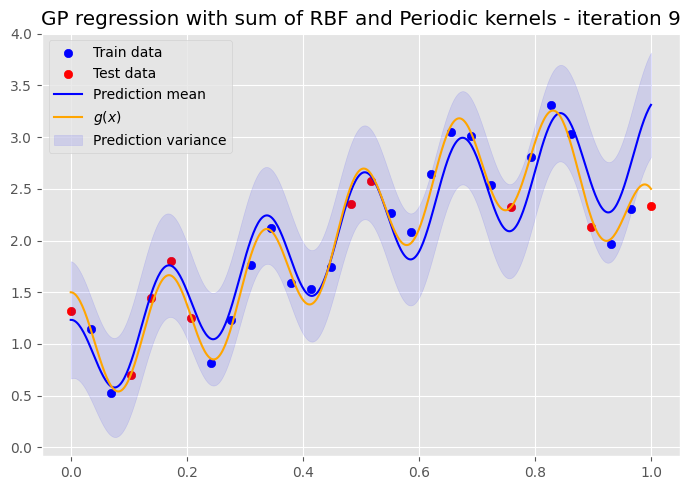

RBF length 1.572033166885376 var 1.1949368715286255
PERIODIC per 0.16964459419250488 length 6.697362899780273 var 4.090076446533203


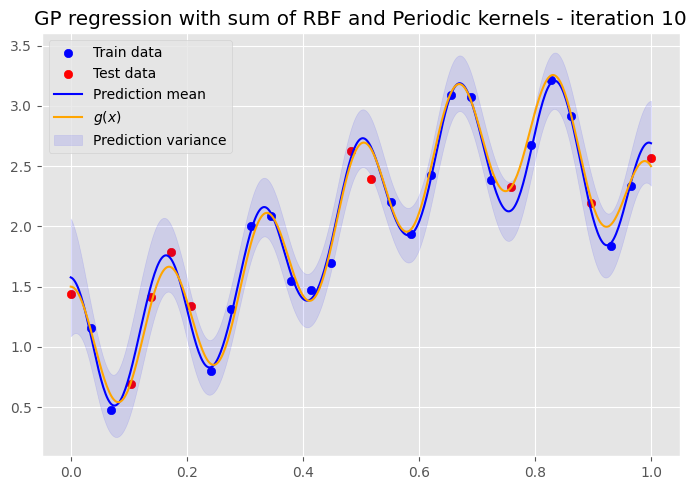

RBF length 0.4808581471443176 var 1.3084897994995117
PERIODIC per 0.16324135661125183 length 4.079728603363037 var 1.3030898571014404


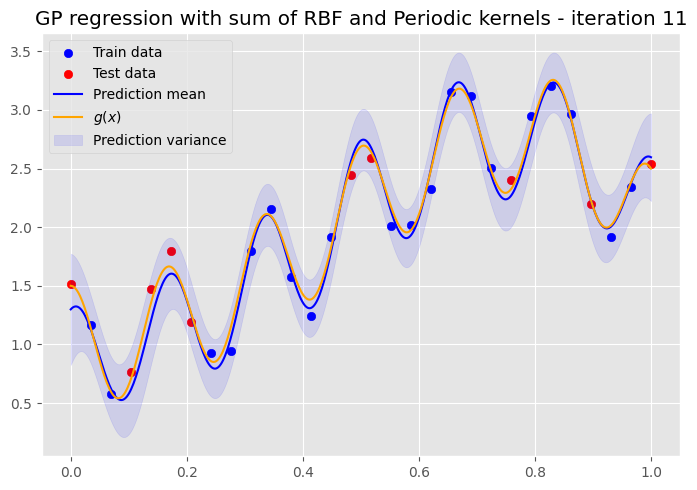

RBF length 0.4936242699623108 var 1.2232751846313477
PERIODIC per 0.1664385348558426 length 6.513003826141357 var 2.3671412467956543


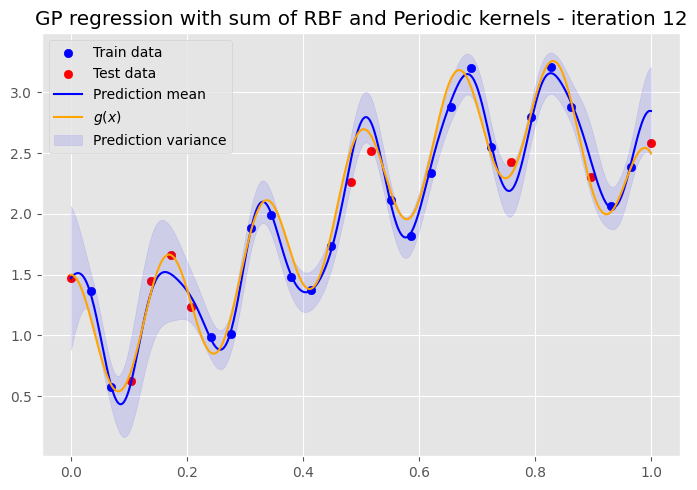

RBF length 0.4171009659767151 var 1.2721672058105469
PERIODIC per 0.18508118391036987 length 2.570932388305664 var 1.255639672279358


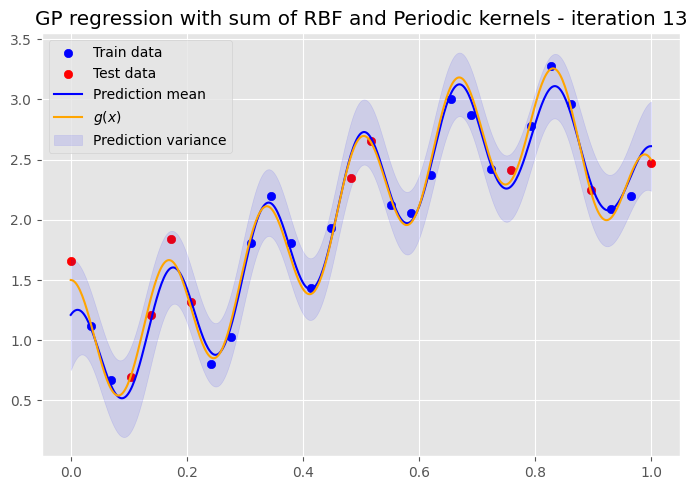

RBF length 0.5439304709434509 var 2.896674156188965
PERIODIC per 0.16592472791671753 length 6.828399658203125 var 0.9557483792304993


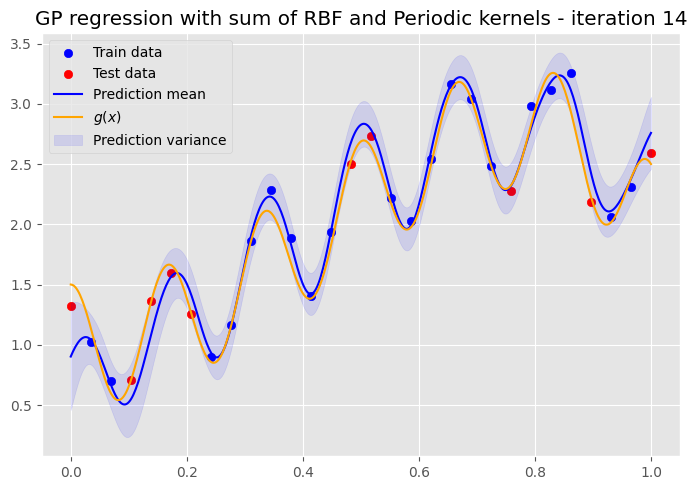

RBF length 0.6190087199211121 var 2.062805652618408
PERIODIC per 0.16300055384635925 length 5.929170608520508 var 3.3419370651245117


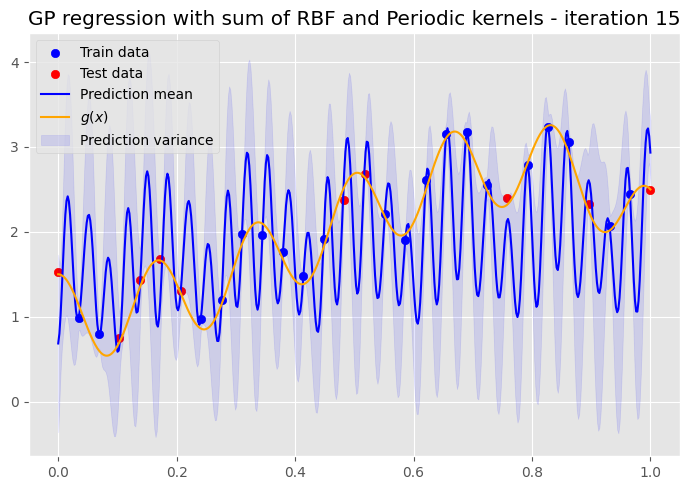

RBF length 1.1713311672210693 var 6.156105995178223
PERIODIC per 0.16896595060825348 length 0.4455677270889282 var 0.3906024992465973


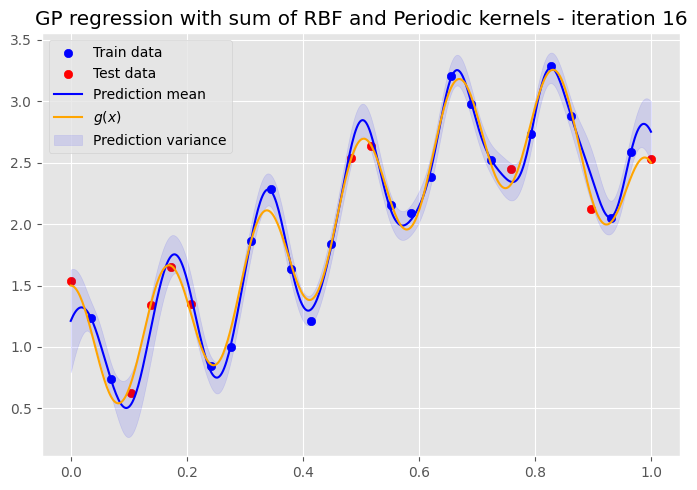

RBF length 0.4510359764099121 var 0.7595276832580566
PERIODIC per 0.15793605148792267 length 3.228200912475586 var 1.845287561416626


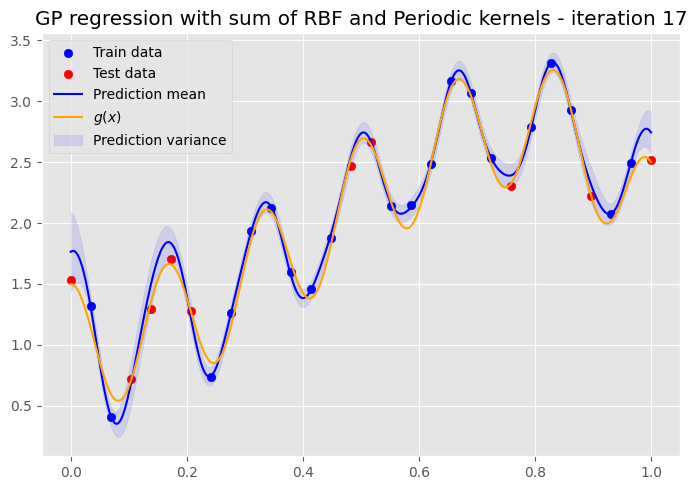

RBF length 0.4906320571899414 var 1.2722768783569336
PERIODIC per 0.1606304943561554 length 3.957341432571411 var 1.5570523738861084


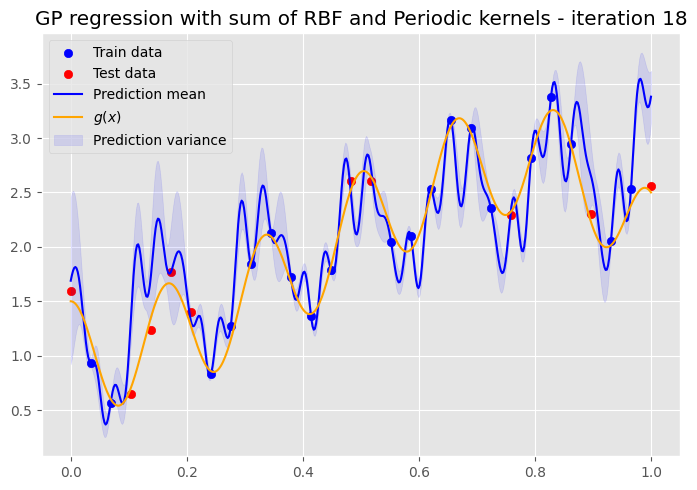

RBF length 1.8792574405670166 var 1.144448161125183
PERIODIC per 0.1801101565361023 length 0.6717718243598938 var 1.9116231203079224


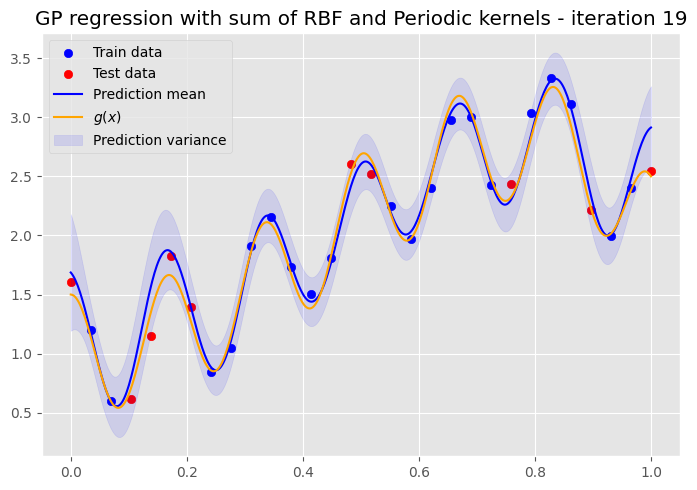

RBF length 0.46064215898513794 var 1.2840211391448975
PERIODIC per 0.17793160676956177 length 3.9094502925872803 var 1.4371237754821777


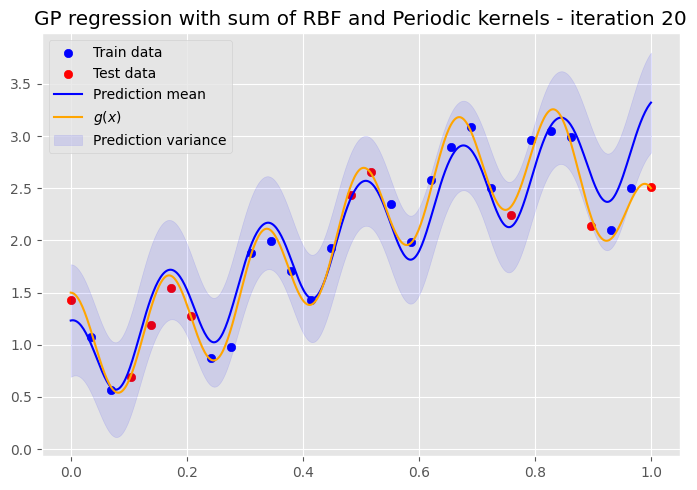

RBF length 1.6974142789840698 var 1.809078574180603
PERIODIC per 0.16899651288986206 length 5.107740879058838 var 2.0805881023406982


In [77]:
for i, gp in enumerate(gaussian_processes):
    pyro.clear_param_store()
    gp.set_mode("guide")
    with torch.no_grad():
        mean, cov = gp(xs, noiseless=False)

    plotfct(generated_data_list, xs, ys, mean, cov, i)

    print(
        f"RBF length {gp.kernel.kern0.lengthscale} var {gp.kernel.kern0.variance}\n"
        f"PERIODIC per {gp.kernel.kern1.period} length {gp.kernel.kern1.lengthscale} var {gp.kernel.kern1.variance}"
    )